<a href="https://colab.research.google.com/github/Nouran246/Fruits-Recognition/blob/main/Fruits_Recognition(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moltean_fruits_path = kagglehub.dataset_download('moltean/fruits')

print('Data source import complete.')
print(f"The dataset has been downloaded to: {moltean_fruits_path}")

# Optionally, you can also check the directory structure
import os
print("Files in the dataset directory:")
print(os.listdir(moltean_fruits_path))

Data source import complete.
The dataset has been downloaded to: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11
Files in the dataset directory:
['fruits-360_dataset_original-size', 'fruits-360_dataset_100x100']


Imports

In [136]:


import numpy as np
import os
import cv2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Loading Dataset for Training and Testing

In [137]:
# Adjusting paths to the dataset after downloading it from Kaggle
train_path = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Training"
test_path = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Test"


# Verify the paths
import os
print(f"Train Path: {train_path}")
print(f"Test Path: {test_path}")

# Check if directories exist
print("Train directory exists:", os.path.exists(train_path))
print("Test directory exists:", os.path.exists(test_path))

Train Path: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Training
Test Path: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Test
Train directory exists: True
Test directory exists: True


In [138]:
def load_train_data(train_path):
    features, labels = [], []
    classes = sorted(os.listdir(train_path))
    for class_name in classes:
        class_path = os.path.join(train_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image = cv2.imread(img_path)
                if image is not None:
                    features.append(image)
                    labels.append(class_name)
    return np.array(features), np.array(labels)

Feature Extraction

In [139]:
def extract_color_histograms(images, bins=32):
    all_histograms = []
    for img in tqdm(images, desc="Extracting Color Histograms", unit="image"):
        resized_img = cv2.resize(img, (100, 100))  # Resize to a fixed size
        hsv_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2HSV)  # Convert to HSV color space
        hist_hue = cv2.calcHist([hsv_img], [0], None, [bins], [0, 256]).flatten()
        hist_saturation = cv2.calcHist([hsv_img], [1], None, [bins], [0, 256]).flatten()
        hist_value = cv2.calcHist([hsv_img], [2], None, [bins], [0, 256]).flatten()
        hist = np.concatenate([hist_hue, hist_saturation, hist_value])
        hist = hist / hist.sum()  # Normalize to get a probability distribution
        all_histograms.append(hist)
    return np.array(all_histograms)



In [140]:
print("Loading training data...")
X_train, y_train = load_train_data(train_path)
print("Loading testing data...")
X_train.shape, y_train.shape

Loading training data...
Loading testing data...


((70491, 100, 100, 3), (70491,))

In [141]:
def load_test_data(test_path):
    features, labels = [], []
    classes = sorted(os.listdir(test_path))
    for class_name in classes:
        class_path = os.path.join(test_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image = cv2.imread(img_path)
                if image is not None:
                    features.append(image)
                    labels.append(class_name)
    return np.array(features), np.array(labels)

In [142]:
print("Loading testing data...")
X_test, y_test = load_test_data(test_path)
X_test.shape, y_test.shape

Loading testing data...


((23619, 100, 100, 3), (23619,))

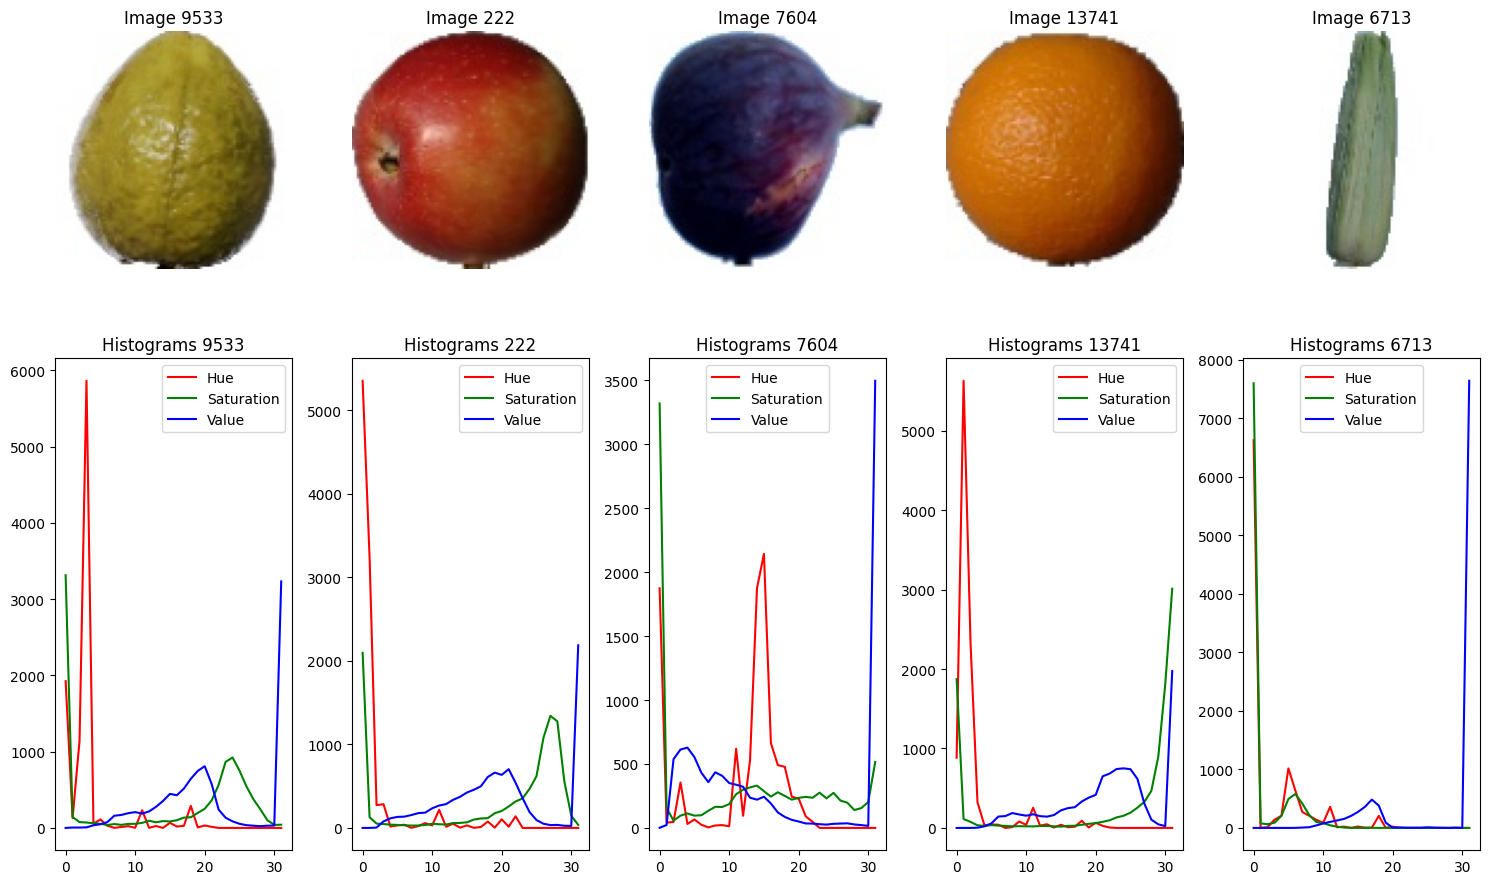

In [143]:

# Visualize color histograms for a few random images from the dataset
def plot_color_histograms(images, bins=32, num_samples=5):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(images)), num_samples)
    for i, idx in enumerate(indices):
        img = cv2.resize(images[idx], (100, 100))  # Resize image
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        hist_hue = cv2.calcHist([hsv_img], [0], None, [bins], [0, 256]).flatten()
        hist_saturation = cv2.calcHist([hsv_img], [1], None, [bins], [0, 256]).flatten()
        hist_value = cv2.calcHist([hsv_img], [2], None, [bins], [0, 256]).flatten()

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Image {idx + 1}")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.plot(hist_hue, color='r', label='Hue')
        plt.plot(hist_saturation, color='g', label='Saturation')
        plt.plot(hist_value, color='b', label='Value')
        plt.title(f"Histograms {idx + 1}")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot color histograms for random images
plot_color_histograms(X_test, bins=32, num_samples=5)

Image Segmentation

In [144]:

# Function for image segmentation using color thresholds (to keep the fruit colored)
def segment_image_with_color(img, hue_min=0, hue_max=179, sat_min=50, sat_max=255, val_min=50, val_max=255):
    """
    Segment an image with a white background and fruit in the foreground using color thresholds.
    Excludes white pixels (high value and low saturation) and isolates the fruit while keeping colors.
    """
    # Convert the image to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Create a mask to exclude white background (where value is high and saturation is low)
    lower_bound_white = np.array([0, 0, 200])  # High value to exclude white
    upper_bound_white = np.array([179, 50, 255])  # Low saturation and high value for white background

    # Mask for non-white pixels (background)
    mask_non_white = cv2.inRange(hsv_img, lower_bound_white, upper_bound_white)
    mask_non_white = cv2.bitwise_not(mask_non_white)  # Invert to focus on non-white areas

    # Define the thresholds for the fruit colors (tune these values for different fruits)
    lower_bound_fruit = np.array([hue_min, sat_min, val_min])
    upper_bound_fruit = np.array([hue_max, sat_max, val_max])

    # Create the fruit mask using the thresholds
    mask_fruit = cv2.inRange(hsv_img, lower_bound_fruit, upper_bound_fruit)

    # Combine the masks: Focus on fruit but exclude white background
    final_mask = cv2.bitwise_and(mask_fruit, mask_non_white)

    # Apply the final mask to the original image to isolate the fruit (colored)
    colored_segmented_img = cv2.bitwise_and(img, img, mask=final_mask)

    return final_mask, colored_segmented_img

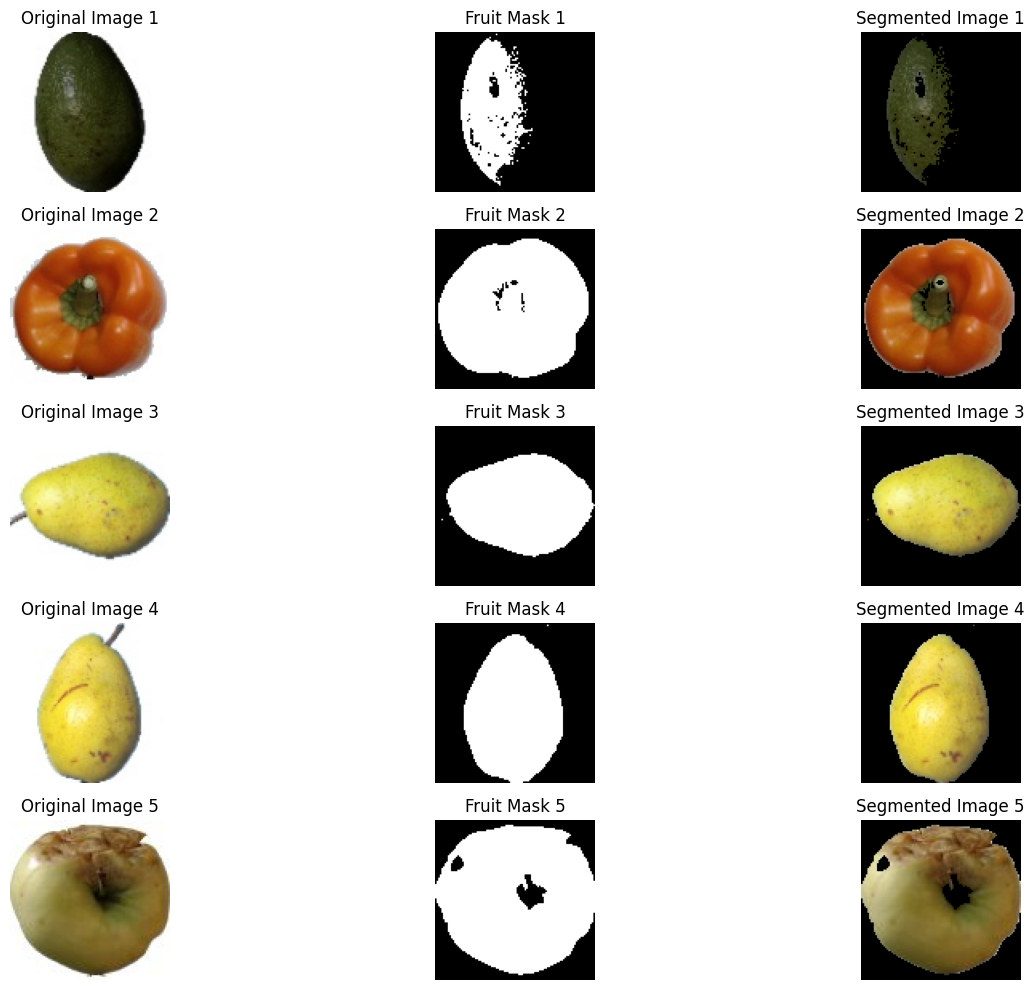

In [145]:
# Function to visualize the segmentation results for random samples
# Function to visualize the segmentation results for random samples
# Function to visualize the segmentation results for random samples
def visualize_segmentation(X_test, num_samples=5):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X_test)), num_samples)

    for i, idx in enumerate(indices):
        img = X_test[idx]

        # Apply the segmentation function with color thresholds
        mask, segmented_img = segment_image_with_color(img, hue_min=0, hue_max=179, sat_min=50, sat_max=255, val_min=50, val_max=255)

        # Display the results
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i + 1}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Fruit Mask {i + 1}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Segmented Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
# Assuming X_test is your test set of images (list or numpy array of images)
# You can call visualize_segmentation function to visualize random segmentation results
visualize_segmentation(X_test, num_samples=5)

Image Enhancement


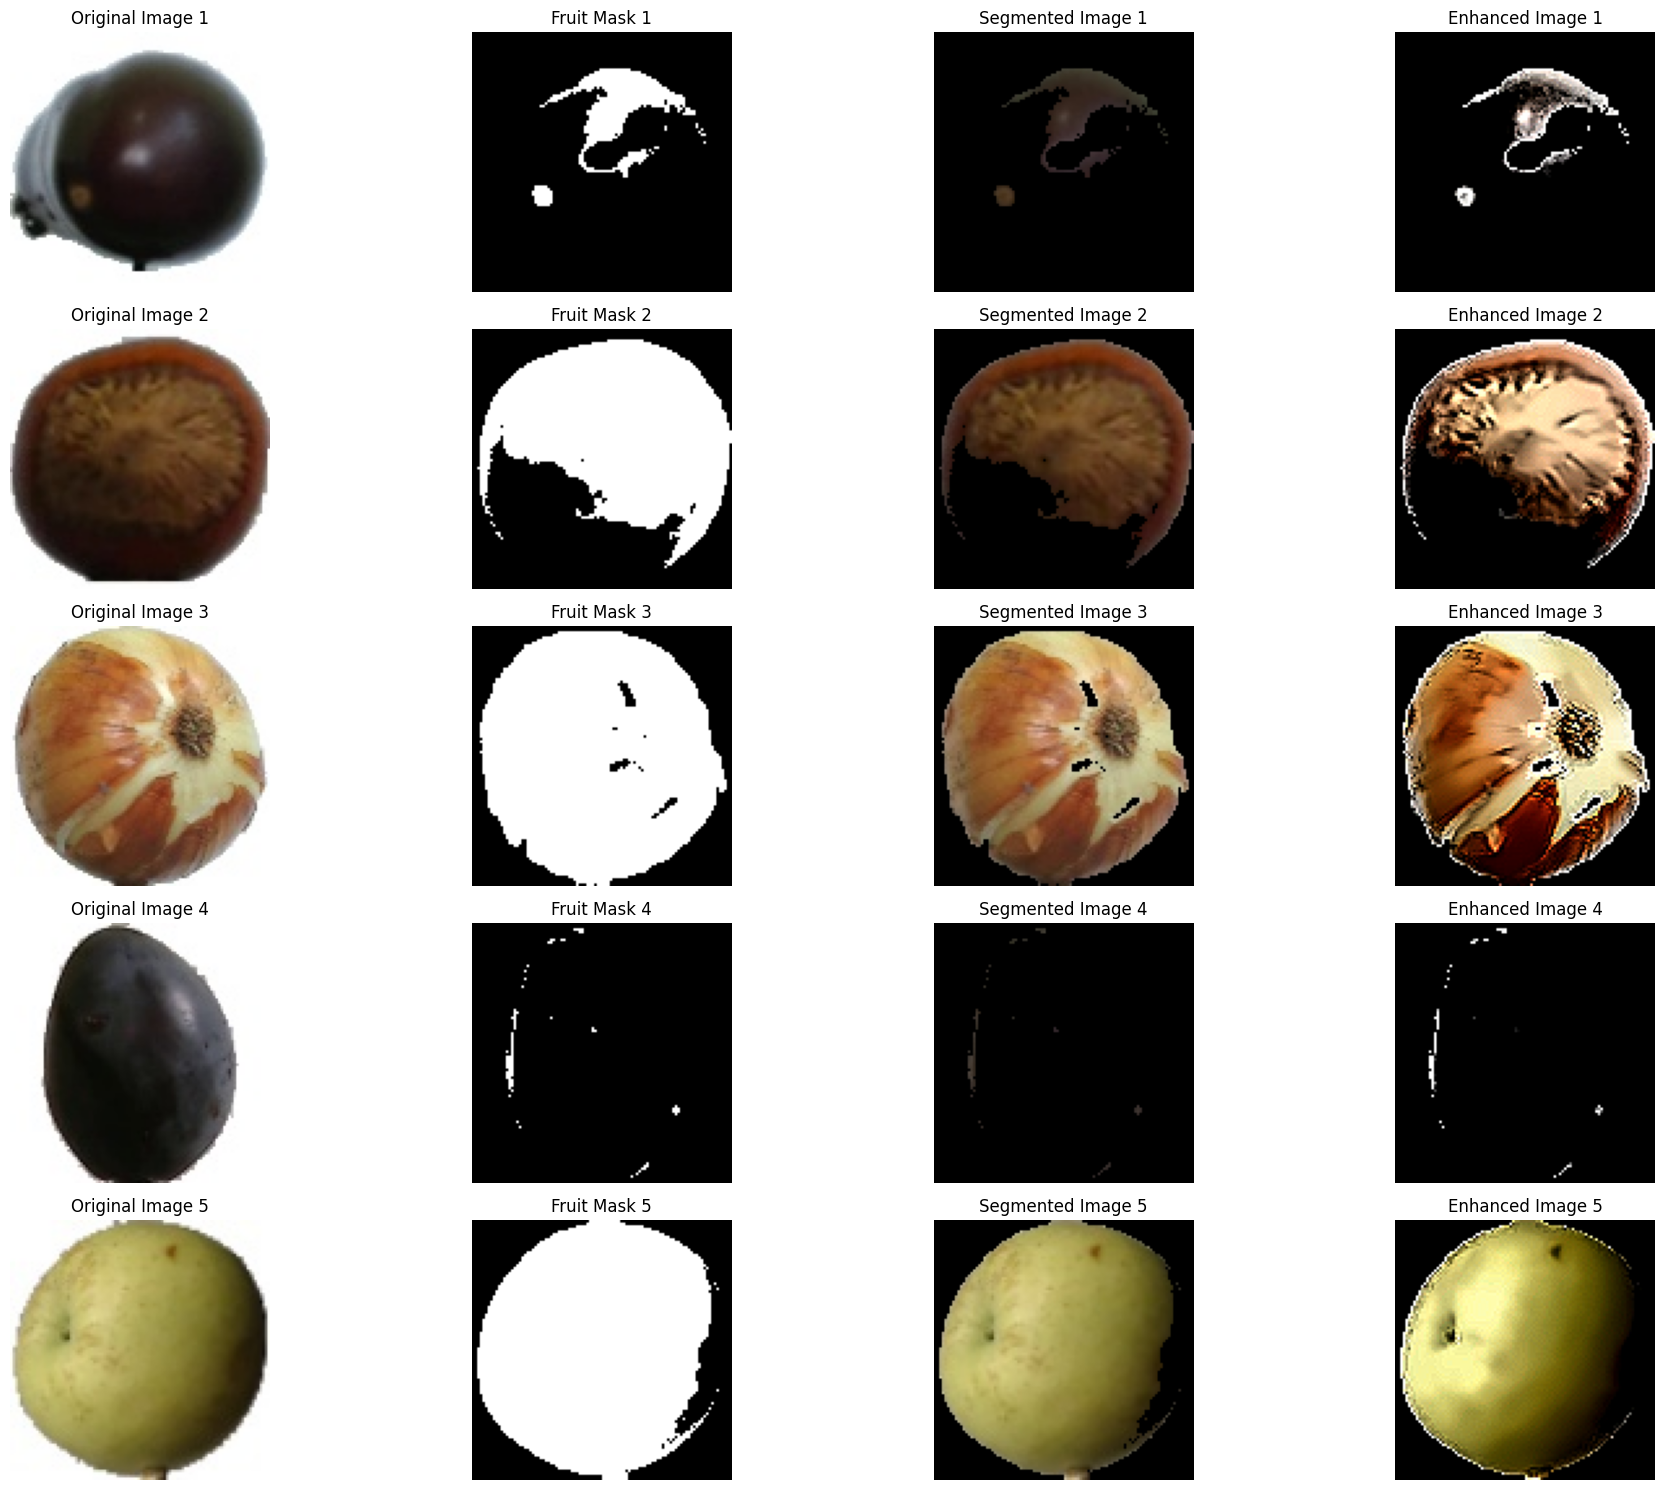

In [146]:
def enhance_image(img):
    """
    Apply image enhancement and restoration techniques to improve the segmented image.
    Techniques:
    1. Brightness and Contrast Adjustment
    2. Histogram Equalization
    3. Denoising
    4. Sharpening
    """
    # 1. Brightness and Contrast Adjustment
    alpha = 1.2  # Contrast control (1.0-3.0)
    beta = 30    # Brightness control (0-100)
    enhanced_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # 2. Histogram Equalization (only for luminance channel in YUV)
    yuv_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2YUV)
    yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])
    enhanced_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)

    # 3. Noise Removal (Denoising)
    denoised_img = cv2.fastNlMeansDenoisingColored(enhanced_img, None, 10, 10, 7, 21)

    # 4. Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_img = cv2.filter2D(denoised_img, -1, kernel)

    return sharpened_img

# Updated Visualization Function with Enhancement
def visualize_segmentation_and_enhancement(X_test, num_samples=5):
    plt.figure(figsize=(20, 15))
    indices = random.sample(range(len(X_test)), num_samples)

    for i, idx in enumerate(indices):
        img = X_test[idx]

        # Apply the segmentation function
        mask, segmented_img = segment_image_with_color(img, hue_min=0, hue_max=179, sat_min=50, sat_max=255, val_min=50, val_max=255)

        # Enhance the segmented image
        enhanced_img = enhance_image(segmented_img)

        # Display the results
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i + 1}")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Fruit Mask {i + 1}")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Segmented Image {i + 1}")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Enhanced Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming X_test is your test set of images
visualize_segmentation_and_enhancement(X_test, num_samples=5)


Preprocessing

In [147]:
# Preprocessing: Standardizing features
def preprocess_features(train_features, test_features):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_features)
    X_test_scaled = scaler.transform(test_features)
    return X_train_scaled, X_test_scaled

In [148]:
# Updated Pipeline with Preprocessing
print("Applying segmentation and enhancement to the training data...")
segmented_enhanced_train = [enhance_image(segment_image_with_color(img, 0, 179, 50, 255, 50, 255)[1]) for img in X_train]

Applying segmentation and enhancement to the training data...


In [149]:
print("Applying segmentation and enhancement to the testing data...")
segmented_enhanced_test = [enhance_image(segment_image_with_color(img, 0, 179, 50, 255, 50, 255)[1]) for img in X_test]


Applying segmentation and enhancement to the testing data...


In [150]:
print("Extracting color histogram features from training data...")
hist_train = extract_color_histograms(segmented_enhanced_train)

Extracting color histogram features from training data...


Extracting Color Histograms: 100%|██████████| 70491/70491 [00:13<00:00, 5178.84image/s]


In [151]:
print("Extracting color histogram features from testing data...")
hist_test = extract_color_histograms(segmented_enhanced_test)

Extracting color histogram features from testing data...


Extracting Color Histograms: 100%|██████████| 23619/23619 [00:03<00:00, 5933.02image/s]


In [152]:
print("Scaling features...")
X_train_scaled, X_test_scaled = preprocess_features(hist_train, hist_test)

Scaling features...


Models Training and Evaluating

In [153]:
# Training and evaluating SVM model
print("Training SVM model...")
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

print("Evaluating SVM model...")
y_pred_svm = svm_classifier.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


Training SVM model...
Evaluating SVM model...
SVM Accuracy: 0.9413607688725179
SVM Classification Report:
                       precision    recall  f1-score   support

              Apple 6       0.67      1.00      0.81       157
     Apple Braeburn 1       0.76      0.88      0.82       164
 Apple Crimson Snow 1       0.88      0.95      0.91       148
       Apple Golden 1       0.91      0.96      0.93       160
       Apple Golden 2       0.99      1.00      1.00       164
       Apple Golden 3       1.00      0.99      1.00       161
 Apple Granny Smith 1       1.00      1.00      1.00       164
    Apple Pink Lady 1       0.80      0.84      0.82       152
          Apple Red 1       0.62      0.73      0.67       164
          Apple Red 2       0.74      0.74      0.74       164
          Apple Red 3       0.73      0.83      0.78       144
Apple Red Delicious 1       0.87      1.00      0.93       166
   Apple Red Yellow 1       0.91      0.99      0.95       164
   Apple Re

In [154]:
# Training and evaluating KNN model with Euclidean distance
print("Training KNN model with Euclidean distance...")
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X_train_scaled, y_train)

print("Evaluating KNN model...")
y_pred_knn = knn_classifier.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_accuracy)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


Training KNN model with Euclidean distance...
Evaluating KNN model...
KNN Accuracy: 0.9178203988314493
KNN Classification Report:
                       precision    recall  f1-score   support

              Apple 6       0.74      1.00      0.85       157
     Apple Braeburn 1       0.62      0.90      0.73       164
 Apple Crimson Snow 1       0.93      0.86      0.90       148
       Apple Golden 1       0.91      0.99      0.95       160
       Apple Golden 2       1.00      0.97      0.98       164
       Apple Golden 3       0.96      1.00      0.98       161
 Apple Granny Smith 1       1.00      1.00      1.00       164
    Apple Pink Lady 1       0.63      0.65      0.64       152
          Apple Red 1       0.71      0.66      0.68       164
          Apple Red 2       0.56      0.81      0.66       164
          Apple Red 3       0.58      0.82      0.68       144
Apple Red Delicious 1       1.00      1.00      1.00       166
   Apple Red Yellow 1       1.00      0.96      0.

In [155]:
# Training and evaluating Random Forest model
print("Training Random Forest model...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

print("Evaluating Random Forest model...")
y_pred_rf = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Training Random Forest model...
Evaluating Random Forest model...
Random Forest Accuracy: 0.9507176425758923
Random Forest Classification Report:
                       precision    recall  f1-score   support

              Apple 6       0.79      1.00      0.88       157
     Apple Braeburn 1       0.75      0.79      0.77       164
 Apple Crimson Snow 1       0.92      0.97      0.95       148
       Apple Golden 1       0.88      0.99      0.93       160
       Apple Golden 2       1.00      1.00      1.00       164
       Apple Golden 3       1.00      1.00      1.00       161
 Apple Granny Smith 1       1.00      1.00      1.00       164
    Apple Pink Lady 1       0.78      0.82      0.80       152
          Apple Red 1       0.73      0.80      0.76       164
          Apple Red 2       0.86      0.95      0.90       164
          Apple Red 3       0.83      0.90      0.87       144
Apple Red Delicious 1       0.92      1.00      0.96       166
   Apple Red Yellow 1       0.96  

In [156]:
# Choosing the better model
if svm_accuracy > knn_accuracy and svm_accuracy > rf_accuracy:
    print("SVM performed better. Using SVM model.")
    best_model = svm_classifier
    y_pred_best = y_pred_svm
elif knn_accuracy > svm_accuracy and knn_accuracy > rf_accuracy:
    print("KNN performed better. Using KNN model.")
    best_model = knn_classifier
    y_pred_best = y_pred_knn
else:
    print("Random Forest performed better. Using Random Forest model.")
    best_model = rf_classifier
    y_pred_best = y_pred_rf

Random Forest performed better. Using Random Forest model.


In [157]:
# Final evaluation
print("Final Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

Final Evaluation:
Accuracy: 0.9507176425758923
Classification Report:
                       precision    recall  f1-score   support

              Apple 6       0.79      1.00      0.88       157
     Apple Braeburn 1       0.75      0.79      0.77       164
 Apple Crimson Snow 1       0.92      0.97      0.95       148
       Apple Golden 1       0.88      0.99      0.93       160
       Apple Golden 2       1.00      1.00      1.00       164
       Apple Golden 3       1.00      1.00      1.00       161
 Apple Granny Smith 1       1.00      1.00      1.00       164
    Apple Pink Lady 1       0.78      0.82      0.80       152
          Apple Red 1       0.73      0.80      0.76       164
          Apple Red 2       0.86      0.95      0.90       164
          Apple Red 3       0.83      0.90      0.87       144
Apple Red Delicious 1       0.92      1.00      0.96       166
   Apple Red Yellow 1       0.96      0.99      0.98       164
   Apple Red Yellow 2       0.87      1.00     

Confusion Matrix

In [158]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='gray', interpolation='nearest')
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=8)
    plt.tight_layout()
    plt.colorbar(label="Intensity (Number of Predictions)")
    plt.show()

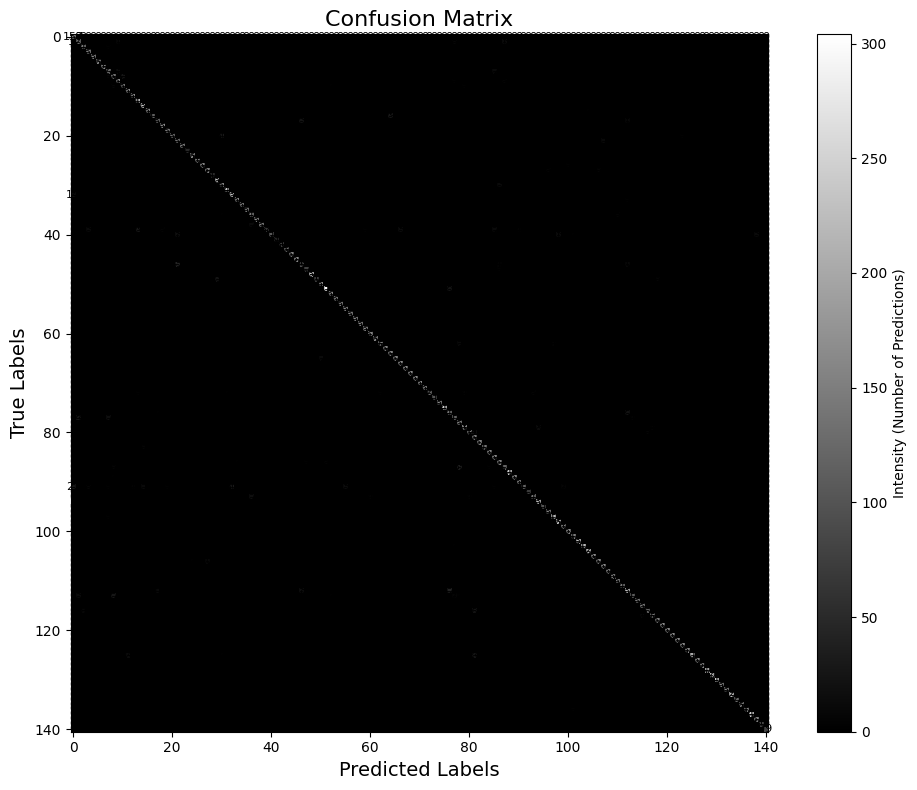

In [159]:
# Generate confusion matrix for the best model
class_names = np.unique(y_test)
plot_confusion_matrix(y_test, y_pred_best, class_names)

Hyperparameter Tuning Using Random Search

In [163]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Hyperparameter search space
param_dist_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_dist_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Define classifiers
svm_classifier = SVC(random_state=42)
knn_classifier = KNeighborsClassifier()
rf_classifier = RandomForestClassifier(random_state=42)

# Perform Random Search on Random Forest
random_search_rf = RandomizedSearchCV(rf_classifier, param_distributions=param_dist_rf, n_iter=10,
                                      cv=3, random_state=42, n_jobs=-1, verbose=1)
random_search_rf.fit(X_train_scaled, y_train)

# Perform Random Search on SVM
random_search_svm = RandomizedSearchCV(svm_classifier, param_distributions=param_dist_svm, n_iter=10,
                                       cv=3, random_state=42, n_jobs=-1, verbose=1)
random_search_svm.fit(X_train_scaled, y_train)

# Perform Random Search on KNN
random_search_knn = RandomizedSearchCV(knn_classifier, param_distributions=param_dist_knn, n_iter=10,
                                       cv=3, random_state=42, n_jobs=-1, verbose=1)
random_search_knn.fit(X_train_scaled, y_train)

# Evaluate the best models
print("Best Random Forest model parameters:", random_search_rf.best_params_)
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print("Best SVM model parameters:", random_search_svm.best_params_)
best_svm_model = random_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

print("Best KNN model parameters:", random_search_knn.best_params_)
best_knn_model = random_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_scaled)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

# Compare the models based on their accuracy
accuracies = {
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'KNN': accuracy_score(y_test, y_pred_knn)
}

best_model_name = max(accuracies, key=accuracies.get)
print(f"The best performing model is {best_model_name} with accuracy: {accuracies[best_model_name]:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest model parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Random Forest Accuracy: 0.9530039375079385
Best SVM model parameters: {'kernel': 'linear', 'gamma': 'auto', 'C': 100}
SVM Accuracy: 0.9459333587366103
Best KNN model parameters: {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'ball_tree'}
KNN Accuracy: 0.9178203988314493
The best performing model is Random Forest with accuracy: 0.9530


Testing function

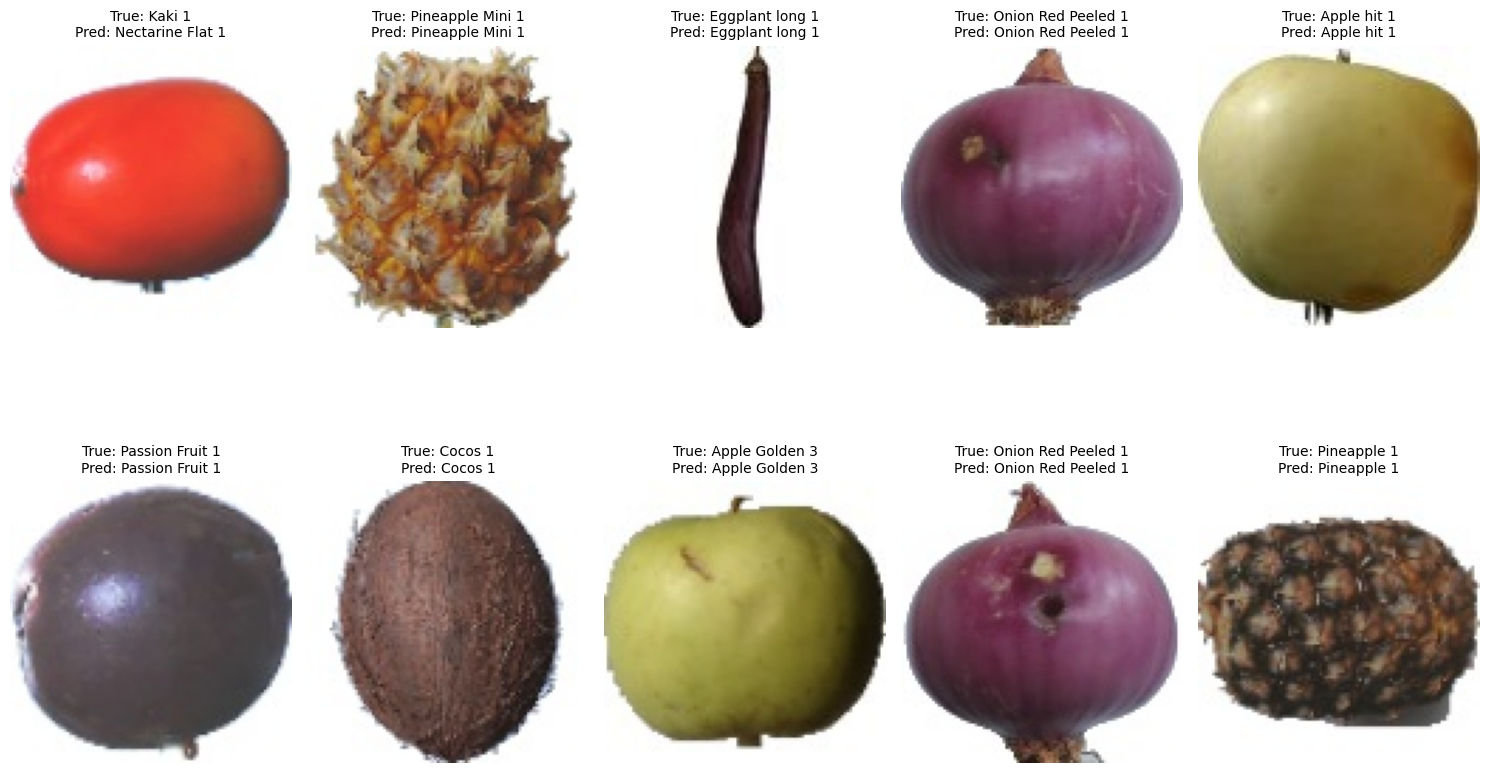

In [165]:
# Visualize random predictions
def visualize_predictions(X_test, y_test, y_pred, num_samples=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X_test)), num_samples)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB))
        true_label = y_test[idx]
        predicted_label = y_pred[idx]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize random predictions for the best model
visualize_predictions(X_test, y_test, y_pred_best, num_samples=10)

Saving Everything for the website Implementation

In [166]:
import pickle

# Save training data
with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

# Save testing data
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Training and testing data saved successfully!")


Training and testing data saved successfully!


In [167]:
# Save extracted features
color_histograms_train = extract_color_histograms(X_train)
color_histograms_test = extract_color_histograms(X_test)

with open("color_histograms_train.pkl", "wb") as f:
    pickle.dump(color_histograms_train, f)
with open("color_histograms_test.pkl", "wb") as f:
    pickle.dump(color_histograms_test, f)

print("Extracted features saved successfully!")


Extracting Color Histograms: 100%|██████████| 23619/23619 [00:03<00:00, 7080.35image/s]

Extracted features saved successfully!


In [168]:
from joblib import dump

# Save an example model (e.g., Random Forest)
rf_model = RandomForestClassifier()
rf_model.fit(color_histograms_train, y_train)

# Save the trained model
dump(rf_model, "random_forest_model.joblib")
print("Model saved successfully!")


Model saved successfully!


<Figure size 640x480 with 0 Axes>

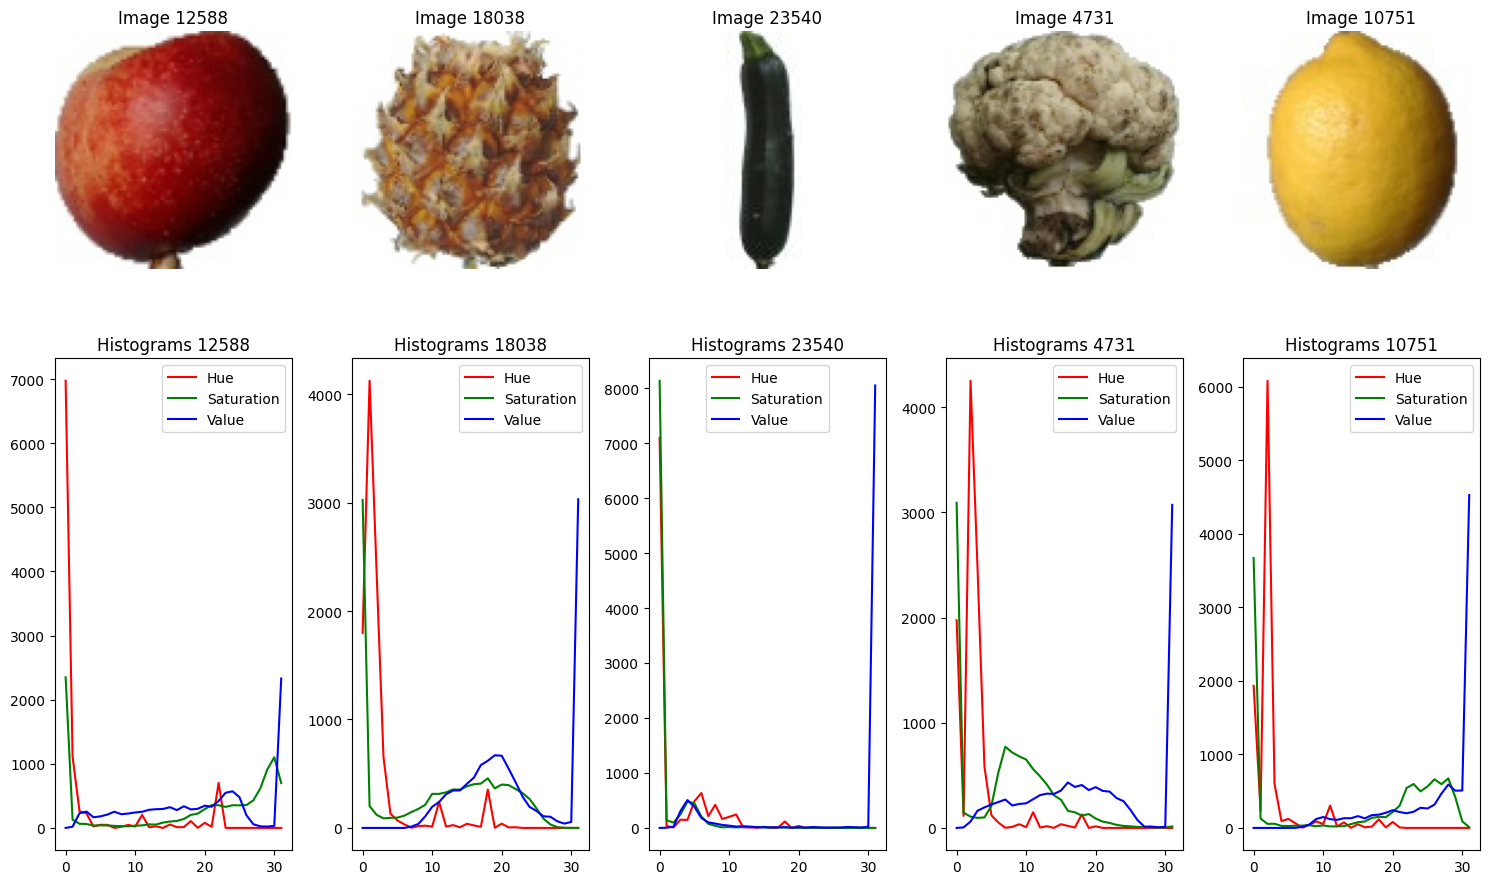

Plots saved successfully!


In [169]:
# Save plots
def save_plot_as_image(plot_func, file_name, *args, **kwargs):
    plt.figure()
    plot_func(*args, **kwargs)
    plt.savefig(file_name)
    plt.close()

# Example: Save a histogram plot
save_plot_as_image(plot_color_histograms, "color_histograms.png", X_test, bins=32, num_samples=5)
print("Plots saved successfully!")


In [170]:
import os

output_dir = "segmented_and_enhanced_images"
os.makedirs(output_dir, exist_ok=True)

# Save segmented and enhanced images
for idx, img in enumerate(X_test):
    mask, segmented_img = segment_image_with_color(img)
    enhanced_img = enhance_image(segmented_img)

    # Save images
    cv2.imwrite(os.path.join(output_dir, f"original_{idx}.png"), img)
    cv2.imwrite(os.path.join(output_dir, f"segmented_{idx}.png"), segmented_img)
    cv2.imwrite(os.path.join(output_dir, f"enhanced_{idx}.png"), enhanced_img)

print("Segmented and enhanced images saved successfully!")


Segmented and enhanced images saved successfully!


In [172]:
import pickle

# Save the best Random Forest model
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

print("Best Random Forest model saved successfully!")

Best Random Forest model saved successfully!


In [173]:
# # Load data
# with open("X_train.pkl", "rb") as f:
#     X_train = pickle.load(f)
# with open("y_train.pkl", "rb") as f:
#     y_train = pickle.load(f)

# # Load model
# from joblib import load
# rf_model = load("random_forest_model.joblib")

# # Load results
# with open("results.json", "r") as f:
#     results = json.load(f)

# print("All files loaded successfully!")
